In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from skimage.io import imread, imshow
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
# authorize access to google drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
# navigate to gdrive home directory
%cd gdrive/MyDrive

# set paths
dir_data = 'projet_radio_covid/COVID-19_Radiography_Dataset/'  # set to local path

lst_group = ['covid', 'normal', 'viral', 'opac']
lst_folders = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
mapper_fname = dict(zip(lst_group, lst_folders))
label_mapper = dict(zip(lst_group, range(4)))

DIRS = dict(zip(lst_group, [os.path.join(dir_data, folder) for folder in lst_folders]))
DIR_IMAGES = dict(zip(lst_group, [os.path.join(dir, 'images') for dir in DIRS.values()]))
DIR_MASKS = dict(zip(lst_group, [os.path.join(dir, 'masks') for dir in DIRS.values()]))

NUM_ALL_IMG = [3616, 10192, 1345, 6012]

/content/gdrive/MyDrive


In [4]:
def get_fname(group, idx):
  return(f"{mapper_fname[group]}-{idx}.png")


def crop_black_border(image):
  assert image.shape[0] == image.shape[1]
  old_dim = image.shape[0]

  mask = image!=0
  mask_row = mask.any(0)
  mask_col = mask.any(1)

  row_range = old_dim - mask_row.argmax() - mask_row[::-1].argmax()
  col_range = old_dim - mask_col.argmax() - mask_col[::-1].argmax() 

  if row_range < col_range:
    top = mask_col.argmax()
    bottom = old_dim - mask_col[::-1].argmax()
    left = mask_row.argmax() - (col_range - row_range)//2
    right = old_dim - mask_row[::-1].argmax() + (col_range - row_range)//2
    if left < 0:
      left, right = 0, col_range
    elif right > old_dim:
      left, right = old_dim - col_range, col_range
  else:
    left = mask_row.argmax()
    right = old_dim - mask_row[::-1].argmax()
    top = mask_col.argmax() - (row_range - col_range)//2
    bottom = old_dim - mask_col[::-1].argmax() + (row_range - col_range)//2
    if top < 0:
      top, bottom = 0, row_range
    elif bottom > old_dim:
      top, bottom = old_dim - row_range, old_dim
  return image[top:bottom, left:right]


def normalize_intensity(img, mean=.2, min=0):
  return(img/img.mean() * (mean - min) + min)


def pipeline(groups=list, num_images=list, image_size=(50, 50), use_mask=True, 
             crop=True, output_type='matrix', **kwargs):
  """
  Parameters
  ------------
  groups: list of categories (labels) of input data
  num_images: list of number of images in each group. pass NUM_ALL_IMG to use all the images in current dataset.
  image_size: tuple: the destinated size of each image. If none, the image will be 256*256. 
  use_mask: bool: whether apply the masks to the radio images.
  crop: bool: whether crop the black border after applying mask. 
  output_type: 'matrix' or 'vector', the output type of an image

  Return:
  ------------
  X_train
  X_test
  y_train
  y_test
  todo 

  """
  X = np.zeros((sum(num_images), 256, 256))
  y = np.zeros(sum(num_images))
  sum_num = 0

  # load the images
  print('image loading ...')
  for group, num in zip(groups, num_images):
    X[sum_num:(sum_num + num), :, :] = [resize(imread(os.path.join(DIR_IMAGES[group], get_fname(group, idx)), as_gray=True), (256, 256), anti_aliasing=True) 
    for idx in range(1, num + 1)]
    y[sum_num:sum_num + num] = [label_mapper[group]] * num
    sum_num += num

  # masking
  if use_mask:
    print('mask loading ...')
    masks = np.zeros((sum(num_images), 256, 256))
    sum_num = 0
    for group, num in zip(groups, num_images):
      masks[sum_num:(sum_num + num), :, :] = [imread(os.path.join(DIR_MASKS[group], get_fname(group, idx)), as_gray=True)
      for idx in range(1, num + 1)]
      sum_num += num
    X = X * masks
    
  # crop the black border and resize
  if crop:
    print('border cropping ...')
    X = np.array([resize(crop_black_border(image), image_size, anti_aliasing=True) for image in X])
  else: 
    print('resizing ...')
    X = resize(X, (X.shape[0], *image_size), anti_aliasing=True)

  # normalize intensity
  if kwargs.get('normalize', False):
    min_intensity = kwargs.get('min', 0)
    mean_intensity = kwargs.get('mean', .2)
    X = normalize_intensity(X, mean=mean_intensity, min=min_intensity)  # todo use min_max as option

  # data split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, shuffle=True, stratify=y)
  
  if output_type == 'matrix':
    return X_train, X_test, y_train, y_test
  elif output_type == 'vector':
    # reshape each image to 1-D vector
    X_train, X_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)

    plt.subplot(221)
    imshow(X_test[1].reshape(image_size))
    plt.subplot(222)
    plt.plot(np.histogram(X_test[1])[0])

    # dimensionality reduction
    dim_vec = kwargs.get('dim')
    assert dim_vec <= X_train.shape[1] 
    if dim_vec == X_train.shape[1]:
      return X_train, X_test, y_train, y_test
    else: 
      print("dimensionality reduction by PCA ...")
      pca = PCA(n_components = dim_vec)
      X_train_pca = pca.fit_transform(X_train)
      X_test_pca = pca.transform(X_test)
      return X_train_pca, X_test_pca, y_train, y_test


image loading ...
mask loading ...
border cropping ...
dimensionality reduction by PCA ...

shapes of X_train, X_test, y_train, y_test:
(32, 10) (8, 10) (32,) (8,)

example of a sample in X_test:
[ 0.64332315 -4.47890536 -1.58840761 -0.20096262 -0.30138344  0.43593132
 -0.61463366 -0.03265646 -0.40704231 -0.63946708]

y_test:
[2. 0. 0. 3. 2. 1. 1. 3.]


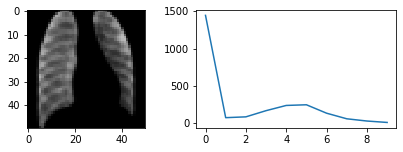

In [10]:
# example 1: test with 10 images per category, do not apply intensity normalization, resize image to 50 * 50 then use PCA to reduce dimension to 10.
X_train, X_test, y_train, y_test = pipeline(
    groups=lst_group, 
    num_images=[10, 10, 10, 10],   # pass NUM_ALL_IMG to use all the images.
    image_size=(50, 50), 
    use_mask=True, 
    crop=True, 
    output_type='vector', 
    dim=10
    )   

print('\nshapes of X_train, X_test, y_train, y_test:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('\nexample of a sample in X_test:')
print(X_test[0])
print('\ny_test:')
print(y_test)


In [11]:
# example 2: test with 10 images per category, applying intensity normalization, output as image of size 50*50. 
X_train, X_test, y_train, y_test = pipeline(
    groups=lst_group, 
    num_images=[10, 10, 10, 10],   # pass NUM_ALL_IMG to use all the images.
    image_size=(50, 50), 
    use_mask=True, 
    crop=True, 
    output_type='matrix', 
    normalize=True
    )   

print('\nshapes of X_train, X_test, y_train, y_test:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('\nexample of a sample in X_test:')
print(X_test[0])
print('\ny_test:')
print(y_test)


image loading ...
mask loading ...
border cropping ...

shapes of X_train, X_test, y_train, y_test:
(32, 50, 50) (8, 50, 50) (32,) (8,)

example of a sample in X_test:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5282964  0.3612665  0.0142589 ]
 [0.         0.         0.         ... 0.42964011 0.35373077 0.01341068]
 [0.         0.         0.         ... 0.1867862  0.26589663 0.0079592 ]]

y_test:
[2. 0. 0. 3. 2. 1. 1. 3.]
